# Тематическая классификация длинных текстов - TFIDF и LogReg

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pickle

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils       # самописная библиотека от авторов курса
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

\*) на видеокарте инициализация сидов не будет приводить к одинаковым результатам...

## Предобработка текстов и подготовка признаков

Примерно 18 тысяч текстов суммарно, из них примерно две трети содержатся в обучающей выборке, а треть в — тестовой.

Длина текста — это несколько предложений плюс какая-то мета-информация. 

Классы в этом датасете обозначаются числами от 0 до 19.

In [2]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


### Подготовка 

В результате подготовки признаков мы получим две прямоугольные матрицы (из обучающей и тестовой выборок), строки которых соответствуют текстам, а столбцы — признакам.

Первый шаг почти для всех задач обработки текстов — это **токенизация** — разбиение исходного текста на базовые лексические элементы, токены. Для этого используется простейшая самописная библиотека, где собраны несложные методы разбора текстов регулярками.

После токенизации у нас остались только последовательности, состоящие из букв и цифр.

In [3]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


Создание словаря (отображение из строкового представления токена в его номер):
- нумеруем все токены и затем в датасете строки заменяем на соответствующие им числа 
- для построения словаря мы используем только обучающую подвыборку
- частоты мы будем хранить в словаре со значением по умолчанию
- когда мы подсчитали частоты токенов, мы удаляем из словаря те токены, которые мы считаем неинформативными (слишком высоко- и низкочастотные по распределению Ципфа)
- добавляем в список наших токенов фиктивный токен, причём добавляем его мы в начало. Мы делаем это для того, чтобы он получил идентификатор "0"

С учётом фильтрации по частоте у нас получилось примерно 20 тысяч уникальных токенов — это достаточно много, на самом деле, для такого датасета

In [4]:
MAX_DF = 0.8        # токены, имеющиеся в >80% документов не нужны
MIN_COUNT = 5       # токеты, встретившиеся 5 и менее раз не нужны
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


Кроме словаря наша функция `build_vocabulary` возвращает ещё вектор весов — "word_to_frequency". Этот вектор содержит относительные частоты всех токенов в нашем датасете. Этот вектор нам понадобится на этапе формирования матрицы признаков. 

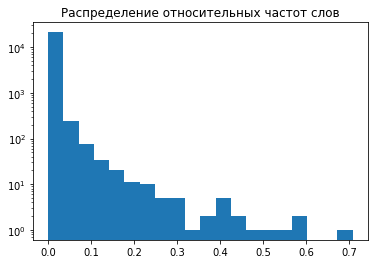

In [5]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

Датасет мы токенизировали, словарь построили, можно перейти и к построению матрицы признаков. Для построения матрицы признаков по методу мешка слов мы будем использовать нашу функцию `vectorize_texts`:

- строим прямоугольную матрицу, в которой количество строк соответствует количеству текстов, а количество столбцов соответствует количеству уникальных токенов (счётчики: сколько каждый токен встретился в каждом документе)
- матрица счётчиков будет крайне разреженная (можем использовать разреженные матрицы из библиотеки scipy)
- реализуем процедуру взвешивания. По умолчанию, в этой функции реализовано 4 алгоритма взвешивания (`{'tfidf', 'idf', 'tf', 'bin'}`)
- используем мин-макс-стандартизацию*
- переводим нашу разреженную матрицу в формат, ориентированный на эффективную работу со строками ([CSR, Compressed Sparse Row matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)), потому, что алгоритмы машинного обучения, которые мы далее будем использовать, читают документы один за другим и настраивают свои веса, то есть нам нужно уметь эффективно брать отдельный документ.


\*) Часто используется приведение к нормальному распределению с мат.ожиданием в нуле и единичной дисперсией. Но такой подход нам здесь не подходит... Потому что у нас матрица разреженная, и если мы сдвинем эту матрицу на её мат.ожидание, то мы получим не разреженную матрицу, и, скорее всего, она у нас для нормального датасета даже в память не влезет.

**Для векторизации и обучающей, и тестовой выборки, используется один и тот же набор параметров, то есть один и тот же словарь, один и тот же вектор частот и один и тот же режим векторизации.**

In [6]:
def get_vectorized_texts(name, *args, **kwargs):
    path_to_obj = os.getcwd() + "/data/" + name + "_20news_vectorized.pkl"

    if os.path.exists(path_to_obj):
        with open(path_to_obj, 'rb') as fp:
            return pickle.load(fp)
    else:
        result = vectorize_texts(*args, **kwargs)
        with open(path_to_obj, 'wb') as fp:
            pickle.dump(result, fp)
        return result

In [7]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = get_vectorized_texts("train", train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = get_vectorized_texts("test", test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в тестовой выборке 721529
Процент заполненности матрицы признаков 0.44%


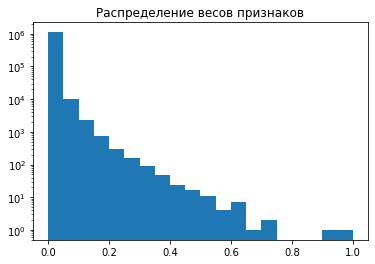

In [8]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

У нас всего 20 классов — классы распределены практически равномерно в обучающей выборке (мы можем смело использовать accuracy (или долю правильных предсказаний) как рабочую метрику). Если бы распределение классов было скошенным, эта метрика было бы уже неподходящей, она бы давала сильно завышенные оценки.

In [9]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


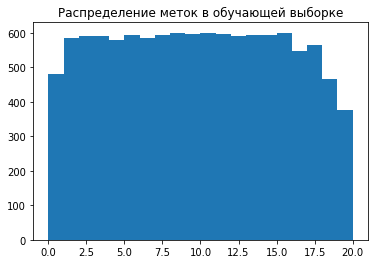

In [10]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

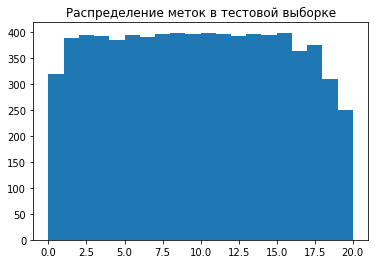

In [11]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

Обернём наши матрицы признаков в "Dataset" — это специальная идиома в pytorch, которая призвана повысить удобство подключения различных датасетов, которые могут подгружаться с жёсткого диска, из памяти; загружаться сразу все — в память, или читаться по чуть-чуть... 

Особенность в том, что "features" — это разреженная матрица, а `pytorch` НЕ умеет работать с разреженными матрицами

Здесь мы используем `SparseFeaturesDataset`. Он описан в наши библиотечке - это очень простой класс, который принимает на вход в конструктор две матрицы — это матрица признаков, которая разрежена, и матрица меток:

- храним весь dataset в разреженном виде, но, когда нам нужно выбрать один пример из датасета, мы выбираем только его из разреженной матрицы, конвертируем в плотное представление и заворачиваем в `torch.Tensor` 
- аналогично поступаем и с метками
- метод "len" должен возвращать длину датасета, то есть количество примеров в нём 
- метод "get item" должен возвращать один обучающий пример, то есть, в случае нашего семинара — это вектор признаков и метка


In [12]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

Наша модель — это **логистическая регрессия** (т.е. линейная регрессия, выход который сжимается в диапазон от нуля до единицы с помощью логистической функции - сигмоиды). 

Т.о. сама модель состоит всего лишь из одного слоя — это линейный слой, у которого количество входов соответствует количеству уникальных токенов, то есть размеру словаря, и количество выходов соответствует количеству меток в датасете. 

Эту нашу модель мы обучаем с помощью САМОПИСНОЙ функции `train_eval_loop`, которая реализует цикл обучения нейросети. Это функция общего назначения, сюда можно подавать модели не только для классификации, не только текстов, в ней реализованы некоторые стандартные фишки, которые используются при обучении нейросетей.

- принимает целую кучу параметров, но среди этих параметров есть четыре главных: 
    - экземпляр модели
    - обучающий датасет
    - валидационный датасет 
    - функция потерь

Порядок работы `train_eval_loop`:

- переносим нашу модель на то устройство, на котором мы будем производить вычисления (CPU / GPU) 
- создаём оптимизатор, то есть — говорим, как именно мы должны делать градиентный шаг на каждой итерации 
- опционально, настраиваем расписание изменения скорости обучения (переменный шаг градиентного спуска — это часто хорошая идея, которая приводит к получению лучших значений метрик и функции потерь) 
- берём Dataset-ы, которые умеют возвращать обучающий пример по индексу (как мы только что рассмотрели), и передаём эти "Dataset" в "DataLoader" — это объект из `pytorch`, который умеет в многопоточном режиме собирать батчи примеров (цель - всегда загружать видеокарты на 100%)
- определяем набор переменных, которые позволят нам, в ходе обучения, выбрать лучшую модель 
    - процесс обучения — стохастический, и модель может как улучшаться в ходе обучения, так и ухудшаться, и не всегда нужно брать последнюю модель 
    - хорошая практика для выбора лучшей модели в процессе обучения заключается в том, чтобы иметь отложенную выборку, состоящую из некоторого количества примеров, не входящих в обучающих выборку. И, после некоторого количества шагов по обучающей выборке, оценивать качество модели на валидационной выборке (то есть на этой отложенной выборке) и сравнивать качество моделей именно по значениям метрик, вычисленных на отложенной выборке. 

- начинается цикл обучения - состоит из нескольких эпох*, включающих:
- цикл, реализующий одну эпоху обучения 
    - заданное количество градиентных шагов по обучающей выборке, на каждом шаге мы берём батч примеров — DataLoader нам возвращает уже не отдельные примеры, а целые пачки примеров
    - переменная "batch_x" — это прямоугольная матрица, в которой количество строк равно количеству примеров в батче, то есть размеру батча, а количество столбцов — это количество признаков
    - копируем данные на то же, устройство на котором была и модель, выполняем прямой проход по модели, получаем предсказания
    - находим значение критерия (то есть значение функции потерь)
    - очищаем оценки градиента с предыдущего шага, находим новое значение градиентов, и делаем градиентный шаг
    - запоминаем среднее значение функции потерь на эпохе. Это полезно для **мониторинга процесса обучения**
    
\*) Эпоха, в данном случае, носит условный характер — это некоторое количество градиентных шагов. Не обязательно эпоха — это полный проход по датасету. Наша эпоха начинается с того, что мы переводим модель в режим обучения.

*Geforce 760GTX (3 сек./эпоха) примерно в 4-5 раз быстрее CPU i5-4440 (14 сек./эпоха)*

In [13]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 354 итераций, 3.79 сек
Среднее значение функции потерь на обучении 2.2252567908858176
Среднее значение функции потерь на валидации 2.113699447805599
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 3.19 сек
Среднее значение функции потерь на обучении 0.9165917320103295
Среднее значение функции потерь на валидации 1.6821936944783744
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 3.38 сек
Среднее значение функции потерь на обучении 0.46601735728945437
Среднее значение функции потерь на валидации 1.4643886998548346
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 3.11 сек
Среднее значение функции потерь на обучении 0.28363620691885383
Среднее значение функции потерь на валидации 1.3450367127434681
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 3.23 сек
Среднее значение функции потерь на обучении 0.19072449459867963
Среднее значение функции потерь на валидации 1.2602410271006115
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 3.06 сек
Среднее значение функции 

По **характеру изменения функции потерь** от эпохи к эпохе мы иногда можем понять, что не так с процессом обучения, мы можем увидеть, что модель вообще не сходится или — она очень быстро достигает определённой точки и дальше не учится, или значение функции потерь изменяется практически случайно, с большой дисперсией. Это важный диагностический показатель, поэтому мы выводим резюме по каждой эпохе. 

Для этого в той же самописной `train_eval_loop`:
1. переводим модель в режим "eval" (то есть, в режим предсказания) и объявляем переменные для оценки среднего значения функции потерь на отложенной выборке
2. повторяем практически те же самые действия, что и делали при обучении, но не делаем сам градиентный шаг — мы только получаем предсказание модели и оцениваем значение функции потерь
    - важный момент, который позволит сэкономить память на видеокарте — это включить режим "torch no_grad". Когда этот режим включён, pytorch не сохраняет промежуточные данные, необходимые для вычисления градиентов
3. сравниваем среднее значение функции потерь на валидации на последней эпохе и лучшее значение функции потерь, полученное аналогичным образом на предыдущих эпохах, и если новое среднее значение функции потерь — лучше, то мы сохраняем текущий вариант модели
    - делаем это с помощью стандартной функции `copy.deepcopy()`
    - если улучшить значение функции потерь на отложенной выборке после этой эпохи не получилось, то мы проверяем — а как давно у нас вообще получалось улучшить модель, если давно (по умолчанию 10 эпох) - то конец обучения
    - если пользователь задал расписание изменения скорости обучения, то мы обновляем скорость обучения с учётом нового значения функции потерь

Тело этого цикла мы обернули в `try-except` и добавили обработку двух видов исключений. Первое — это "interrupt", то есть — чтобы пользователь мог досрочно остановить обучение, нажав "Ctrl-C" в Jupyter ноутбуке. И второй обработчик ловит вообще все исключения и печатает их в удобоваримой виде.

**Return**

`train_eval_loop` возвращает 2 объекта:
- лучшее значение функции потерь 
- модель с лучшими весами

Полезные детали реализации основного цикла обучения:

1. Изменение шага градиентного спуска:
    - менять длину градиентного шага (увеличить) тогда, когда в течение пяти эпох значение функции потерь на валидации не улучшилось
2. Функцию потерь мы используем CrossEntropy из pytorch
    - позволяет нам убрать сигмоиду из самой модели и сделать процесс вычислений чуть более численно стабильным, то есть избежать слишком больших чисел или слишком маленьких. Это должно положительно сказаться на точности вычислений. *В данном конкретном случае это не требуется, просто хорошая практика*

3. Вычисления ограничены: 200 проходов по датасету, то есть 200 эпох, размер батча 32
    - на 28 и 38 эпохах уменьшается шаг обучения
    - на 43 эпохе пришли к тому, что 10 последних эпох изменение функции потерь меньше порога и обучения закончено.
    - данные цифры варьируются в небольших пределах в зависимости от сидов (+/-5-10 эпох)

## Оценка качества

Для удобства написали специальную функцию `predict_with_model`:

- принимает на вход модель, датасет, идентификатор устройства (на котором необходимо производить вычисления), размер батча
- в цикле, идёт по этому датасету, применяет модель и сохраняет результаты в список, а потом этот список преобразовывает в матрицу
- на выходе у нас получается матрица, в которой количество строк соответствует количеству элементов в нашем датасете (количеству примеров в нашем датасете), а количество столбцов соответствует количеству классов
- вычисляем значение функции потерь на обучающей выборке, а также оцениваем "accuracy", то есть долю верных ответов

In [14]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:02<00:00, 123.50it/s]


Среднее значение функции потерь на обучении 0.0022322197910398245
Доля верных ответов 0.9994696835778681



236it [00:01, 124.94it/s]                             


Среднее значение функции потерь на валидации 0.9289424419403076
Доля верных ответов 0.76805629314923


**Что мы видим** 


- Модель очень хорошо работает на обучающей выборке и гораздо хуже - на валидационной.
- Модель выделила случайные закономерности, не существующие в процессах реального мира, породивших обучающую выборку.

Обучающую выборку модель практически запомнила — она идеально работает на обучающей выборке. Но на валидационной выборке она даёт верные ответы только в 77% случаев. Значение функции потерь на обучении — порядка нескольких тысячных, а на валидации — почти 1, то есть, значение функции потерь на валидации на два порядка больше, чем значение функции потерь на обучении. Это верный сигнал к тому, что наша модель **переобучилась**. Но даже, несмотря на такое сильное переобучение, в целом, доля верных ответов не такая плохая.

# Альтернативная реализация на scikit-learn

Все вышеприведенное реализуется сайкит-слёрмом в 5 строчек.

- задаём параметры алгоритма векторизации текстов
- указываем токенизатор
- задаём те же параметры для фильтрации токенов по частоте
- говорим, что мы будем использовать логистическую регрессию 
- обучаем

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

## Оценка качества

In [16]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.4954788918582493
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.6539022582340466
Доля верных ответов 0.8190387679235263


- Доля верных ответов на обучающей выборке — поменьше, то есть наша реализация давала accuracy 0.99, реализация scikit-learn даёт 0.96
- На валидации, реализация scikit-learn работает лучше на 4%
- Об этом же говорит и гораздо меньший разброс значения функции потерь

# Выводы

- познакомились с одной из самых базовых моделей текста — **методом мешка слов**, а также, с одной из базовых моделей машинного обучения — **логистической регрессией**

- рассмотрели все этапы подготовки текстов для того, чтобы подавать их в **нейросети**

- рассмотрели некоторые универсальные компоненты, которые можно использовать для разных задач — не только для тематической классификации и даже не только для текстов:

    - токенизацию, 
    - построение словаря, 
    - фильтрацию словаря, 
    - построение матрицы, 
    - использование pytorch Dataset, 
    - основной цикл обучения и валидации, 
    - выбор лучшей модели в процессе обучения, 
    - оценку качества

# До.за.

Предлагаем Вам поэкспериментировать с кодом этого семинара, чтобы попробовать улучшить качество на отложенной выборке. Что можно попробовать сделать:

    - изменить способ взвешивания признаков
    - реализовать взвешивание признаков с помощью точечной взаимной информации (PMI)
    - изменить способ стандартизации данных (см. начиная с 4:25 на шаге 6), например, запоминая сдвиг и масштаб с обучающей выборки и применяя эти параметры для стандартизации тестовой выборки; и/или стандартизируя каждый столбец по отдельности
    добавить регуляризацию
    - извлекать признаки не через токены, а через N-граммы
    - добавить стемминг или простую лемматизацию
    - изменить архитектуру нейросети, например, сделав два слоя вместо одного
    - проанализировать, как сильно падает качество классификации с уменьшением размера словаря (для фильтрации словаря можно использовать разные эвристики, например, тот же PMI)


Подробно, как-нибудь потом, наверное. 

Подбор гиперпараметров по сетке - долго и скучно. Пока просто потыкаем имеющиеся опции по-отдельности по сравнению с базовым вариантом:

- добавление L2-регуляризации с любой значимой величиной лямбды (>0.0001):
    -  застревание в бесполезном локальном минимуме - точность **0,05** (лажа)
- уменьшение объема подвыборки (`batch_size`):
    - точность 0,76 (почти не меняется)
- тип векторизации (отображения слов в вещественные вектора):
    - `idf` - точность 0,75 (-1%)
    - `tf` - точность 0,81 (+5%)
    - `bin` - точность 0.72 (-4%)
- масштабирование признаков:
    - отключили - точность 0.66 (-10%)
- токенизация:
    - исключили менее редкие и более частотные токены - сузили словарь почти в 2 раза (21тыс. -> 12тыс.) - точность 0.78 (+2%)

Лучшие вместе:
- еще сильнее сузили словарь (до 9,5 тыс. слов)
- векторизация токенов `tf`

**0,79 (+3%)**

In [17]:
MAX_DF = 0.75       # токены, имеющиеся в >75% документов не нужны
MIN_COUNT = 15      # токены, встретившиеся 10 и менее раз не нужны
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 9497
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


In [18]:
VECTORIZATION_MODE = 'tf'        # {'tfidf', 'idf', 'tf', 'bin'}
train_vectors = get_vectorized_texts("train2", train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE, scale=True)
test_vectors = get_vectorized_texts("test2", test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE, scale=True)

train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

In [19]:
model_plus = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model_plus,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 354 итераций, 2.87 сек
Среднее значение функции потерь на обучении 1.0285664128381653
Среднее значение функции потерь на валидации 1.0335667519751242
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 2.84 сек
Среднее значение функции потерь на обучении 0.16352276093626428
Среднее значение функции потерь на валидации 0.8858465251781172
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 2.94 сек
Среднее значение функции потерь на обучении 0.06637607571684707
Среднее значение функции потерь на валидации 0.8403291975037527
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 3.07 сек
Среднее значение функции потерь на обучении 0.0368096472058803
Среднее значение функции потерь на валидации 0.8068118878340317
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 2.72 сек
Среднее значение функции потерь на обучении 0.02524110681961401
Среднее значение функции потерь на валидации 0.7851940952872826
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 3.01 сек
Среднее значение функции

In [20]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:02<00:00, 150.27it/s]


Среднее значение функции потерь на обучении 0.00460641598328948
Доля верных ответов 0.9993812975075128



236it [00:01, 151.36it/s]                             

Среднее значение функции потерь на валидации 0.753052294254303
Доля верных ответов 0.7900955921402018
